In [1]:
import numpy as np
import os
import cv2

from datetime import datetime

from sklearn.model_selection import train_test_split

from keras import mixed_precision
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, BackupAndRestore, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from plot_history_lib import plot_history, plot_precision_recall, plot_confusion_matrix
from models_lib import MiniVGGModel

2024-02-20 19:47:54.709102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 19:47:54.709130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 19:47:54.710238: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-20 19:47:54.716424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 19:47:55.695525: W tensorflow/compiler/tf2

# ETL

## Підготовка даних CIFAR-10

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

**Підготовка тренувальних даних котів і собак**

In [3]:
folder_path_train = "cat_dog/train"

current_directory = os.getcwd()
full_path_train = os.path.normpath(os.path.join(current_directory, folder_path_train))

train_images = []
train_labels = []
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def resize_image(img):
    return cv2.resize(img, (32, 32))

num_dogs = 0
num_cats = 0
target_images = 1000

for filename in os.listdir(full_path_train):
    if filename.endswith(".jpg"):
        image_path = os.path.join(full_path_train, filename)
        img = cv2.imread(image_path)
        img = resize_image(img)

        label = filename.split(".")[0]
        if label == "cat" and num_cats < target_images / 2:
            train_images.append(img)
            train_labels.append(class_names.index("cat"))
            num_cats += 1
        elif label == "dog" and num_dogs < target_images / 2:
            train_images.append(img)
            train_labels.append(class_names.index("dog"))
            num_dogs += 1

        if num_cats + num_dogs == target_images:
            break

**Розширення тренувального набору даних та підготовка до навчання**

In [4]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_labels = train_labels.reshape(-1, 1)

X_train = np.concatenate((X_train, train_images), axis=0)
y_train = np.concatenate((y_train, train_labels), axis=0)

In [5]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

size_dataset = X_train.shape[0]
size_test_dataset = X_test.shape[0]
size_vall_dataset = X_valid.shape[0]

batch_size = 128

# EDA
**Налаштування генераторів даних для тренування, тестування та валідації**

In [7]:
mixed_precision.set_global_policy("mixed_bfloat16")

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=10,
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

**Налаштування ранньої зупинки, резервного копіювання та відновлення, зменшення швидкості навчання та журналування з TensorBoard**

In [9]:
folder_backup = "backup"
folder_log = "log"

folder_path_backup = os.path.normpath(os.path.join(current_directory, folder_backup))
folder_path_log = os.path.normpath(os.path.join(current_directory, folder_log))

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, start_from_epoch=10, verbose=1)

backup = BackupAndRestore(backup_dir=folder_path_backup, save_freq=5, delete_checkpoint=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=25, min_lr=0.00045)

log_dir = folder_path_log + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Навчання:

In [10]:
filtermodel = MiniVGGModel()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[early_stopping, backup, tensorboard, reduce_lr]
)

2024-02-20 19:48:00.822068: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/500


/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-02-20 19:48:12.259194: I external/local_xla/xla/service/service.cc:168] XLA service 0x55e8d07e96f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 19:48:12.259226: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-02-20 19:48:12.612951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 19:48:13.750001: I external/local_xla/xla/stream_executor/c

352/360 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3005 - loss: 2.2580 - precision_class0: 0.4755 - precision_class1: 0.4284 - precision_class2: 0.3262 - precision_class3: 0.2684 - precision_class4: 0.3459 - precision_class5: 0.3728 - precision_class6: 0.4668 - precision_class7: 0.5020 - precision_class8: 0.5080 - precision_class9: 0.4363 - recall_class0: 0.1530 - recall_class1: 0.1319 - recall_class2: 0.0317 - recall_class3: 0.0179 - recall_class4: 0.0508 - recall_class5: 0.0453 - recall_class6: 0.1351 - recall_class7: 0.1265 - recall_class8: 0.1725 - recall_class9: 0.1151

2024-02-20 19:49:21.760302: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_80', 4 bytes spill stores, 56 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_63', 4 bytes spill stores, 56 bytes spill loads



360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3023 - loss: 2.2516 - precision_class0: 0.4779 - precision_class1: 0.4325 - precision_class2: 0.3291 - precision_class3: 0.2709 - precision_class4: 0.3479 - precision_class5: 0.3756 - precision_class6: 0.4702 - precision_class7: 0.5053 - precision_class8: 0.5109 - precision_class9: 0.4392 - recall_class0: 0.1542 - recall_class1: 0.1351 - recall_class2: 0.0321 - recall_class3: 0.0181 - recall_class4: 0.0510 - recall_class5: 0.0462 - recall_class6: 0.1373 - recall_class7: 0.1290 - recall_class8: 0.1752 - recall_class9: 0.1173

2024-02-20 19:49:34.093013: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 35389440 exceeds 10% of free system memory.
2024-02-20 19:49:34.131387: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 70778880 exceeds 10% of free system memory.
2024-02-20 19:49:34.182463: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 141557760 exceeds 10% of free system memory.
2024-02-20 19:49:34.254297: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 283115520 exceeds 10% of free system memory.
2024-02-20 19:49:34.376659: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 566231040 exceeds 10% of free system memory.


360/360 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.3026 - loss: 2.2508 - precision_class0: 0.4782 - precision_class1: 0.4330 - precision_class2: 0.3295 - precision_class3: 0.2712 - precision_class4: 0.3482 - precision_class5: 0.3759 - precision_class6: 0.4706 - precision_class7: 0.5057 - precision_class8: 0.5113 - precision_class9: 0.4396 - recall_class0: 0.1544 - recall_class1: 0.1355 - recall_class2: 0.0322 - recall_class3: 0.0181 - recall_class4: 0.0511 - recall_class5: 0.0463 - recall_class6: 0.1376 - recall_class7: 0.1293 - recall_class8: 0.1756 - recall_class9: 0.1175 - val_accuracy: 0.1276 - val_loss: 3.5909 - val_precision_class0: 0.6667 - val_precision_class1: 0.0000e+00 - val_precision_class2: 0.1412 - val_precision_class3: 0.0000e+00 - val_precision_class4: 0.0000e+00 - val_precision_class5: 0.0000e+00 - val_precision_class6: 0.0000e+00 - val_precision_class7: 0.0000e+00 - val_precision_class8: 0.6727 - val_precision_class9: 0.0000e+00 - val_recall_class0: 0.0038 - va

**Візуалізація історії навчання:**

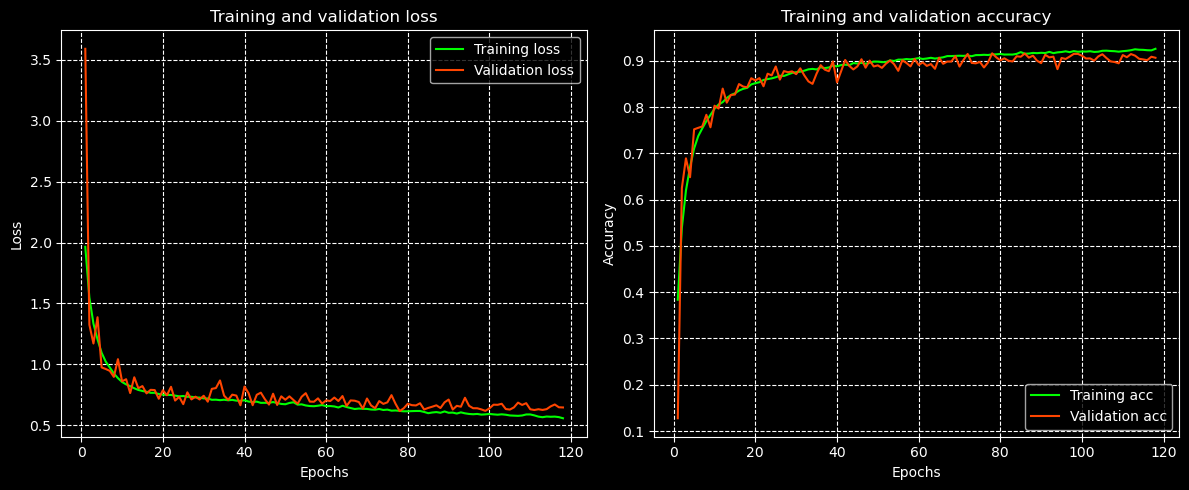

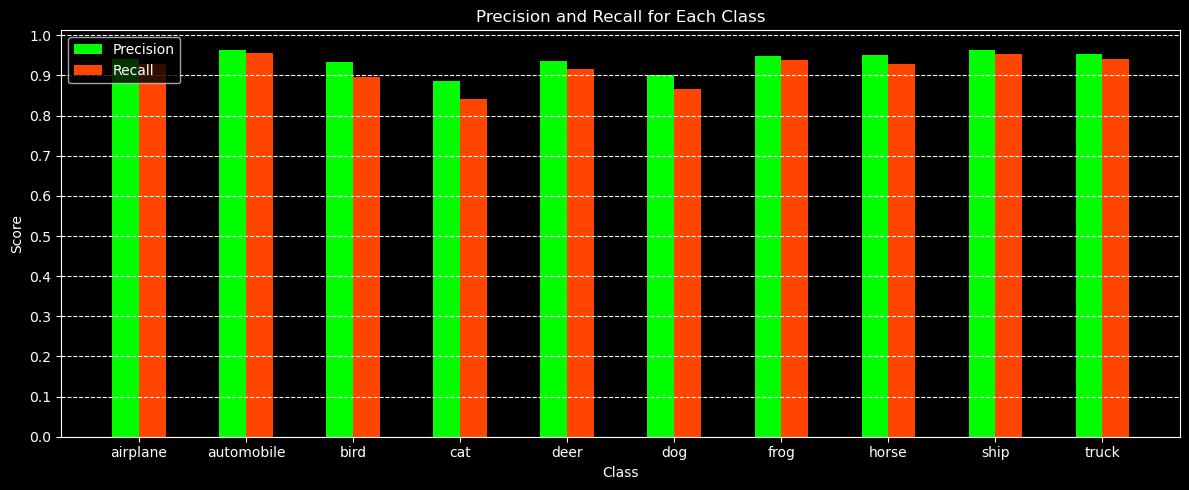

In [11]:
plot_history(history)
plot_precision_recall(history, class_names)


**Оцінка точності моделі**

In [12]:
test_acc = model_filter.evaluate(test_generator)
print("test acc:", test_acc[1])

 9/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9154 - loss: 0.6579 - precision_class0: 0.9431 - precision_class1: 0.9978 - precision_class2: 0.9370 - precision_class3: 0.9458 - precision_class4: 0.8934 - precision_class5: 0.7999 - precision_class6: 0.9247 - precision_class7: 0.9724 - precision_class8: 0.9565 - precision_class9: 0.9221 - recall_class0: 0.8848 - recall_class1: 0.8742 - recall_class2: 0.8637 - recall_class3: 0.7955 - recall_class4: 0.9241 - recall_class5: 0.8370 - recall_class6: 0.9507 - recall_class7: 0.9241 - recall_class8: 0.9567 - recall_class9: 0.9972

/home/alex/anaconda3/envs/env_for_gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9084 - loss: 0.6664 - precision_class0: 0.9374 - precision_class1: 0.9836 - precision_class2: 0.9331 - precision_class3: 0.9039 - precision_class4: 0.9201 - precision_class5: 0.8208 - precision_class6: 0.9172 - precision_class7: 0.9628 - precision_class8: 0.9313 - precision_class9: 0.9115 - recall_class0: 0.8910 - recall_class1: 0.9177 - recall_class2: 0.8498 - recall_class3: 0.7639 - recall_class4: 0.9015 - recall_class5: 0.8569 - recall_class6: 0.9319 - recall_class7: 0.9273 - recall_class8: 0.9538 - recall_class9: 0.9692
test acc: 0.9079999923706055


In [13]:
y_pred_prob = model_filter.predict(X_test/255.)
y_pred = np.argmax(y_pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


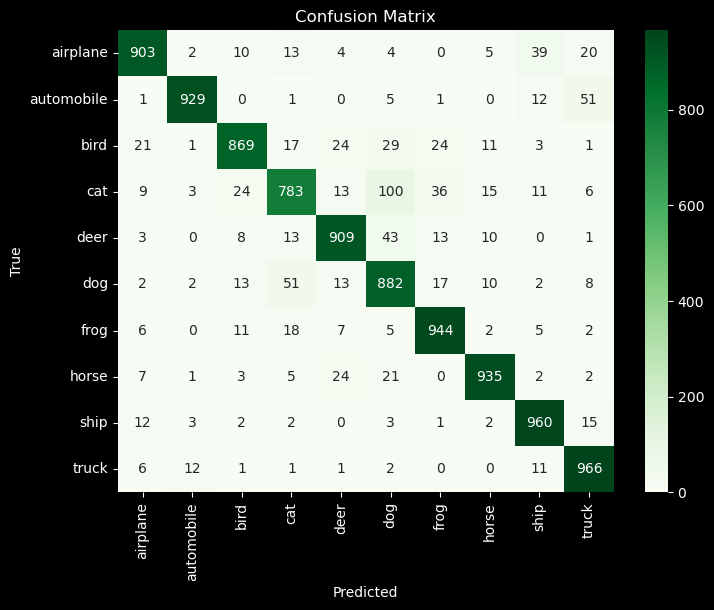

In [14]:
plot_confusion_matrix(y_test, y_pred, class_names)

In [15]:
folder_save = "trained_models"
time = datetime.now().strftime("%Y%m%d-%H%M%S")
name_file = f"model_cifar10_vgg4_{time}.keras"

folder_path_save = os.path.normpath(os.path.join(current_directory, folder_save, name_file))

model_filter.save(folder_path_save)